<h1><center>Bayesian Computation project, Spring 2019</center></h1>
<center>Charles Dufour, Sciper: 257587</center>


In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [3]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot, compare_samples_MH,visualisation
from src.optimization import gradient_descent as GD

In [4]:
import src.maths.func_stats as fstats

# Load the data

In [5]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")
y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
X, X_test, Y, Y_test,y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

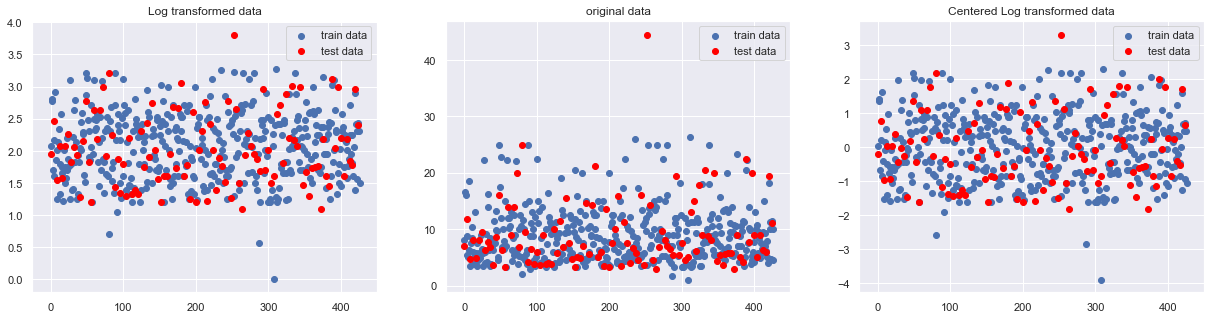

In [6]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

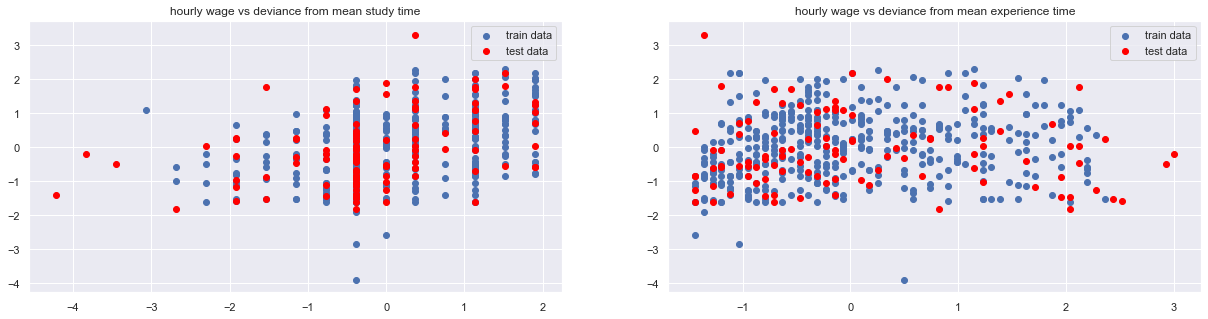

In [7]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.savefig("regressors.png",dpi = 300, bbox_inches = "tight")
plt.show()

# Create the models

`model_gausian`:

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


`model_student`:
    
- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$    

In [8]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

## Obtaining estimates of the parameters

## using MAP

#### using vanilla gradient descent

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$

Progress : [====================] 100% Done...
   duration: 0:00:14


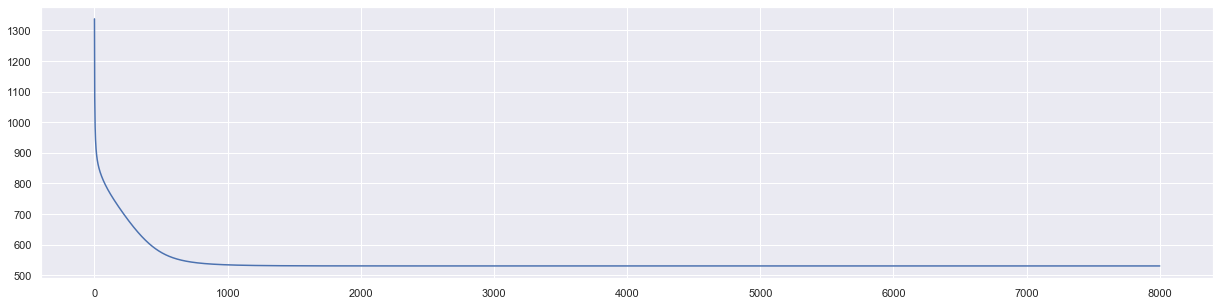

In [9]:
Value = GD.vanilla_gd(model_gaussian, max_iter= 8000, trace = True)
plt.plot(Value[1])
plt.show()

Progress : [====================] 100% Done...
   duration: 0:00:17


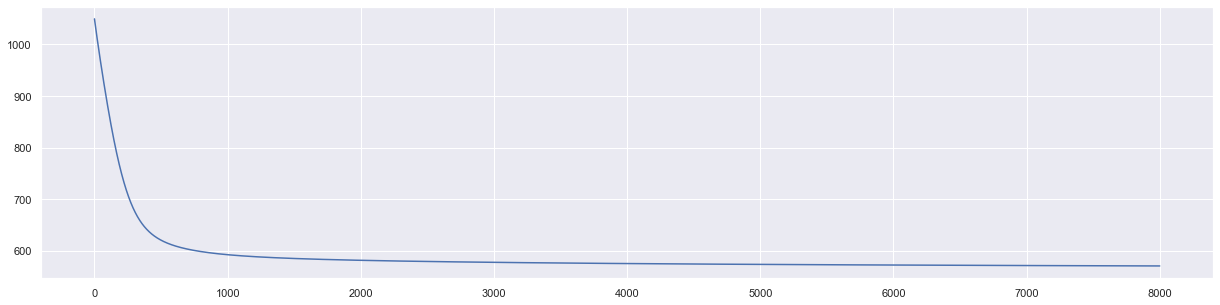

In [10]:
Value = GD.vanilla_gd(model_student, max_iter= 8000, trace = True)
plt.plot(Value[1])
plt.show()

#### using line search

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$
additional condition: accept if 
$$f(\theta_{n+1})< f(\theta_n) -\eta\epsilon||\nabla_\theta f(\theta_n)||_2^2$$

Progress : [====================] 100% Done...
 converged early at iteration 797  duration: 0:00:02


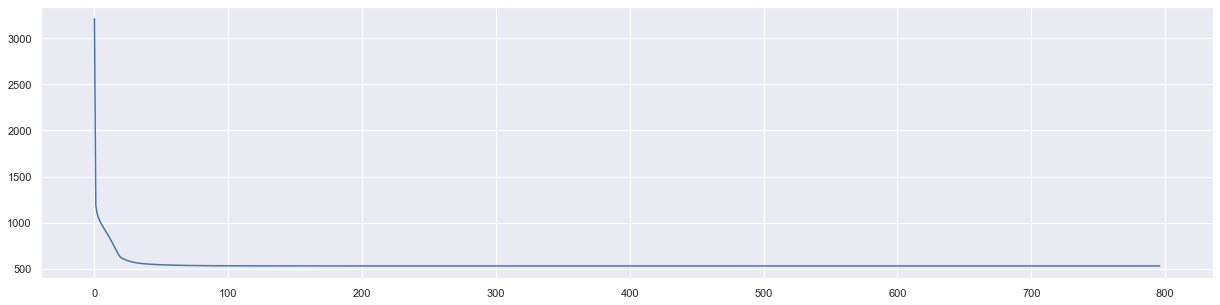

In [11]:
Value = GD.line_search_gd(model_gaussian, lambda_ = 1e-3,x0 = np.ones(model_gaussian.size),max_iter = 8000, trace = True)
plt.plot(Value[1])
plt.show()

Progress : [====================] 100% Done...
   duration: 0:00:26


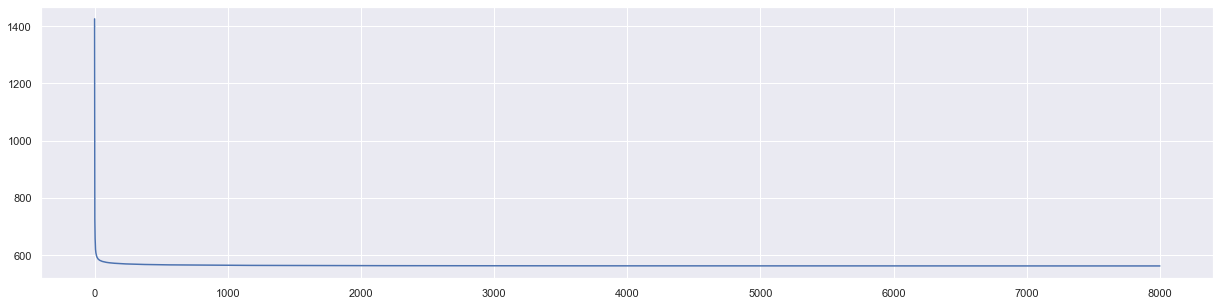

In [12]:
Value = GD.line_search_gd(model_student, lambda_ = 1e-2,x0 = np.ones(model_student.size),max_iter = 8000, trace = True)
plt.plot(Value[1])
plt.show()

#### using Wolfe condition to adpat the step size

Check the Wolfe condition and adapt the step size accordingly: $p_k = \nabla f(x_k)$,   $ \quad 0<c_1<c_2<1$

if $f(x_k + \alpha_kp_k) \leq f(x_k) + c_1\alpha_kp_k^T\nabla f(x_k)$  then reduce step size $\alpha_k$

if $-p_k^T\nabla f(x_k+\alpha_kp_k) \leq -c_2p_k^T\nabla f(x_k)$ then increase step size 

else accept update

Progress : [====================] 100% Done...
   duration: 0:00:56


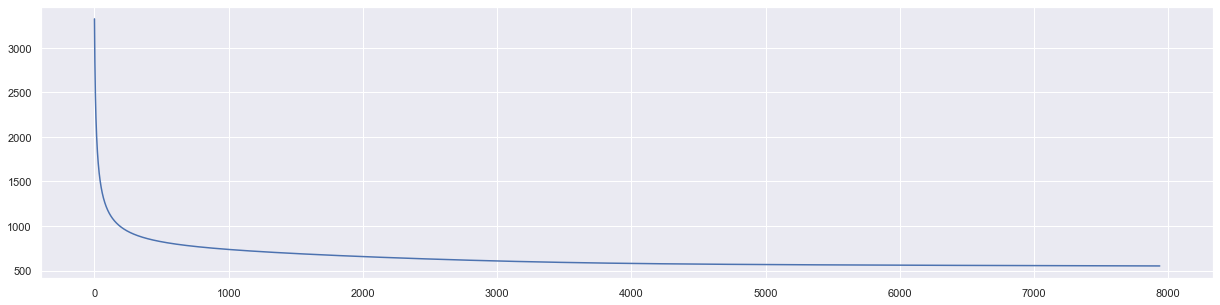

In [13]:
Value = GD.Wolfe_cond_gd(model_gaussian, max_iter = 8000, c1 = 1e-1, initial= 0.5*np.ones(model_gaussian.size),trace = True)
plt.plot(Value[1])
plt.show()

Progress : [====================] 100% Done...
   duration: 0:01:15


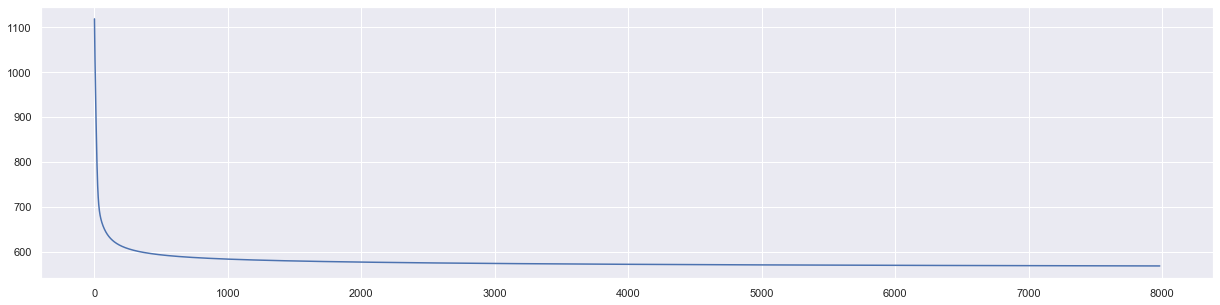

In [14]:
Value = GD.Wolfe_cond_gd(model_student, max_iter = 8000, c1 = 1e-1, initial= 0.5*np.ones(model_student.size), trace = True)
plt.plot(Value[1])
plt.show()

## Using Metropolis Hastings

#### with gaussian random walk

Progress : [====================] 100% Done...
  Acceptance rate : 15.7%  (advised values between 10% and 50%)
  duration: 0:00:12
iterations


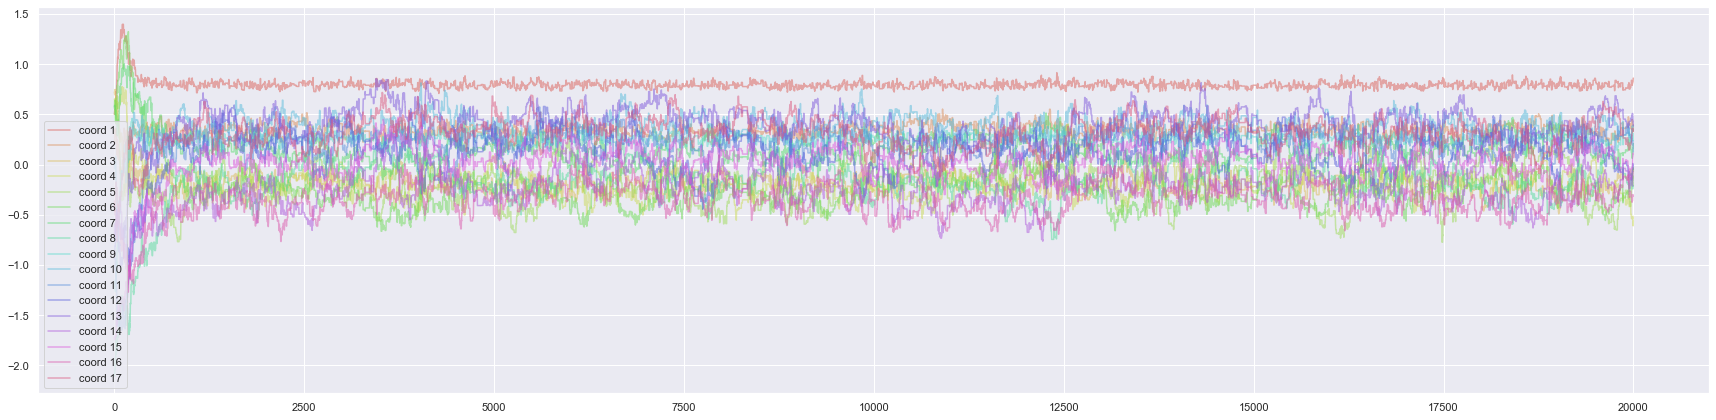

In [15]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_rw = MH.random_walk_MH(model_gaussian, max_iter = 20000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 39.5%  (advised values between 10% and 50%)
  duration: 0:00:12
iterations


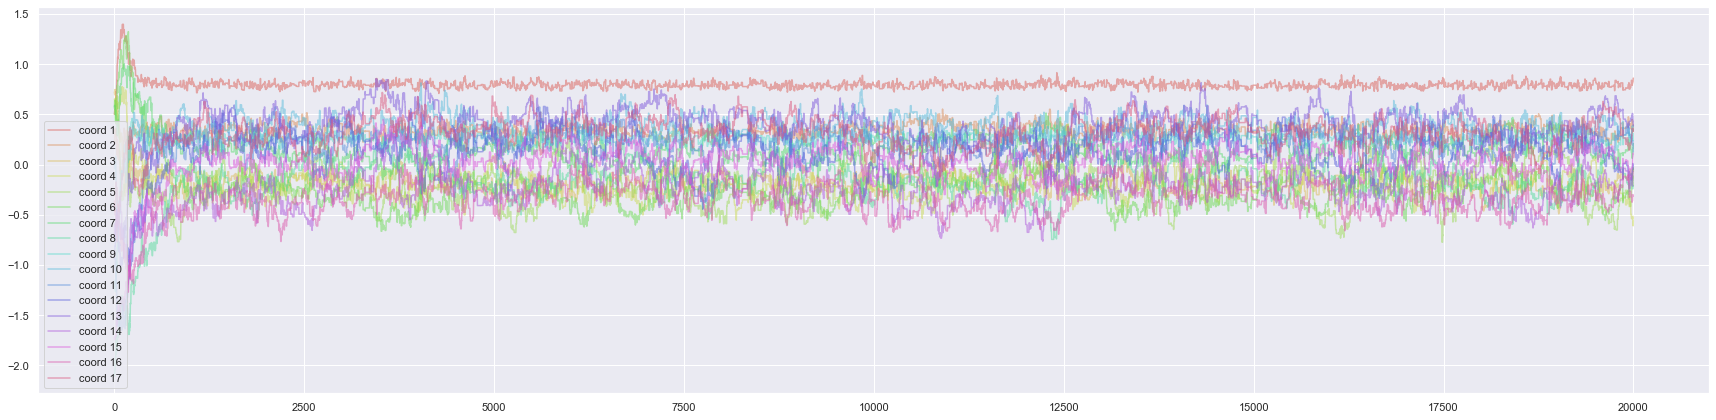

In [16]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 5
    samples_student_rw = MH.random_walk_MH(model_student, max_iter = 20000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

#### with Langevin correction

Progress : [====================] 100% Done...
  Acceptance rate : 59.2%                 (advised values between 10% and 50%)
  duration: 0:01:27
iterations


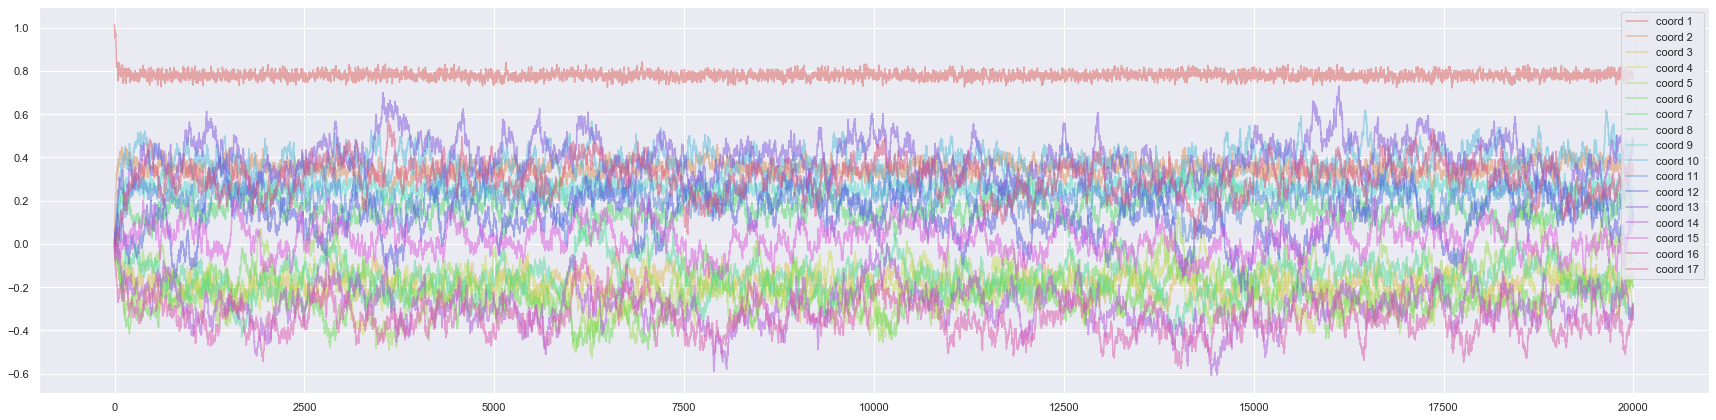

In [17]:
with warnings.catch_warnings(record=True):
    initial = np.zeros(model_gaussian.size)
    initial[0]=1
    samples_gaussian_langevin = MH.Langevin_MH(model_gaussian, max_iter = 20000, initial = initial,verbose = True, tau = 1e-4,RETURN=True)
    samples_exploration(samples_gaussian_langevin,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 25.2%                 (advised values between 10% and 50%)
  duration: 0:01:56
iterations


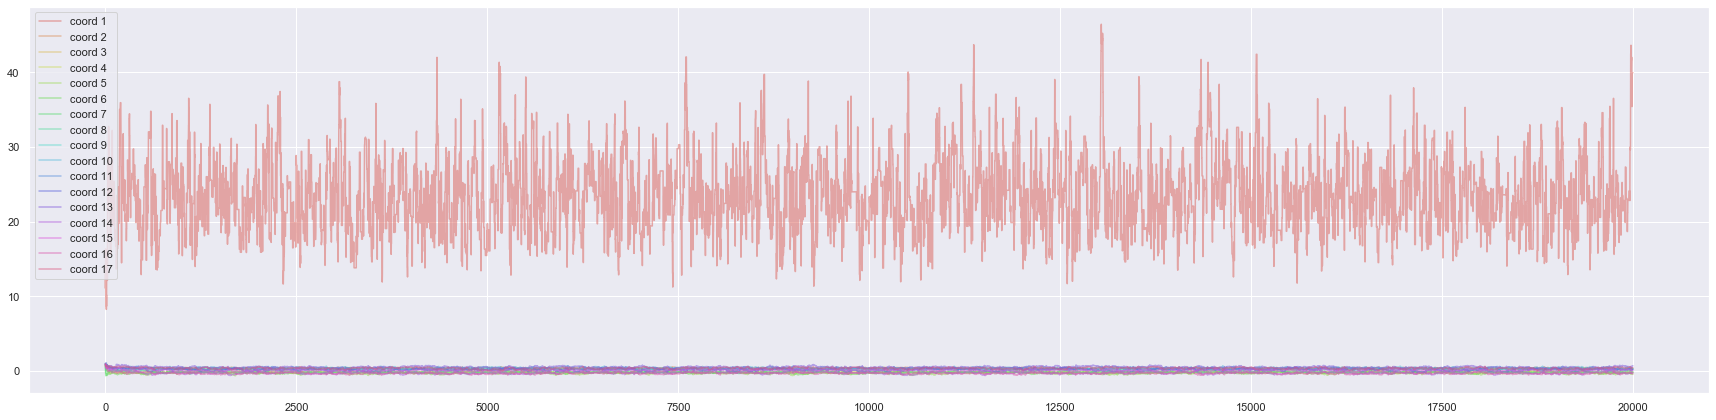

In [18]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    initial[0]=12
    step_size = np.ones(model_student.size)
    step_size[0] = 100
    samples_student_langevin = MH.Langevin_MH(model_student, max_iter = 20000, initial = initial, tau = 1e-3, RETURN=True,step_size = step_size)
    samples_exploration(samples_student_langevin,correlation=False, distribution = False)

#### comparison of the metropolis hastings chains

gaussian model

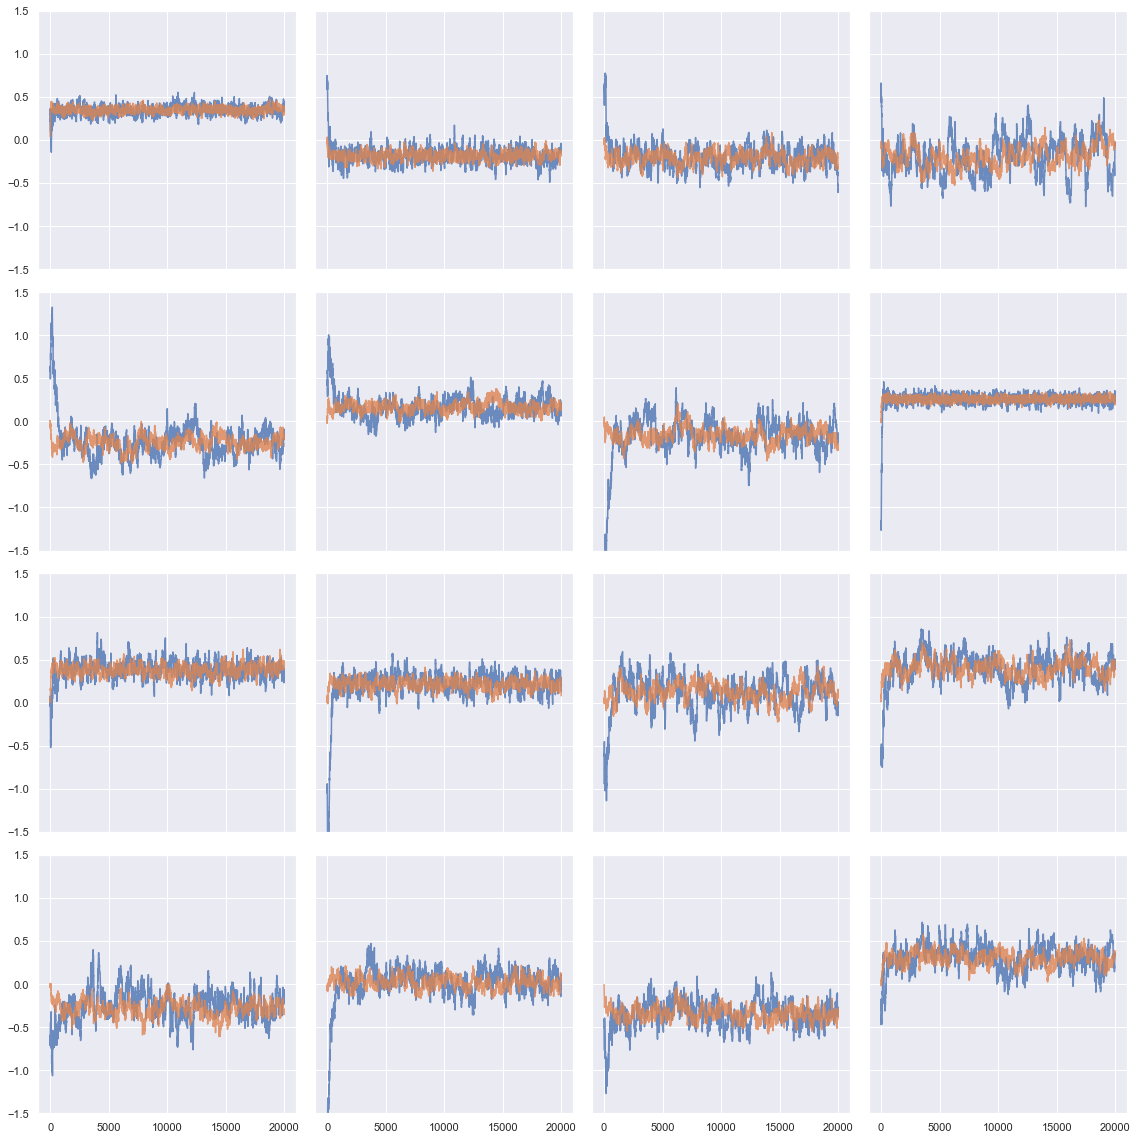

In [19]:
compare_samples_MH(samples_gaussian_rw,samples_gaussian_langevin)

student model

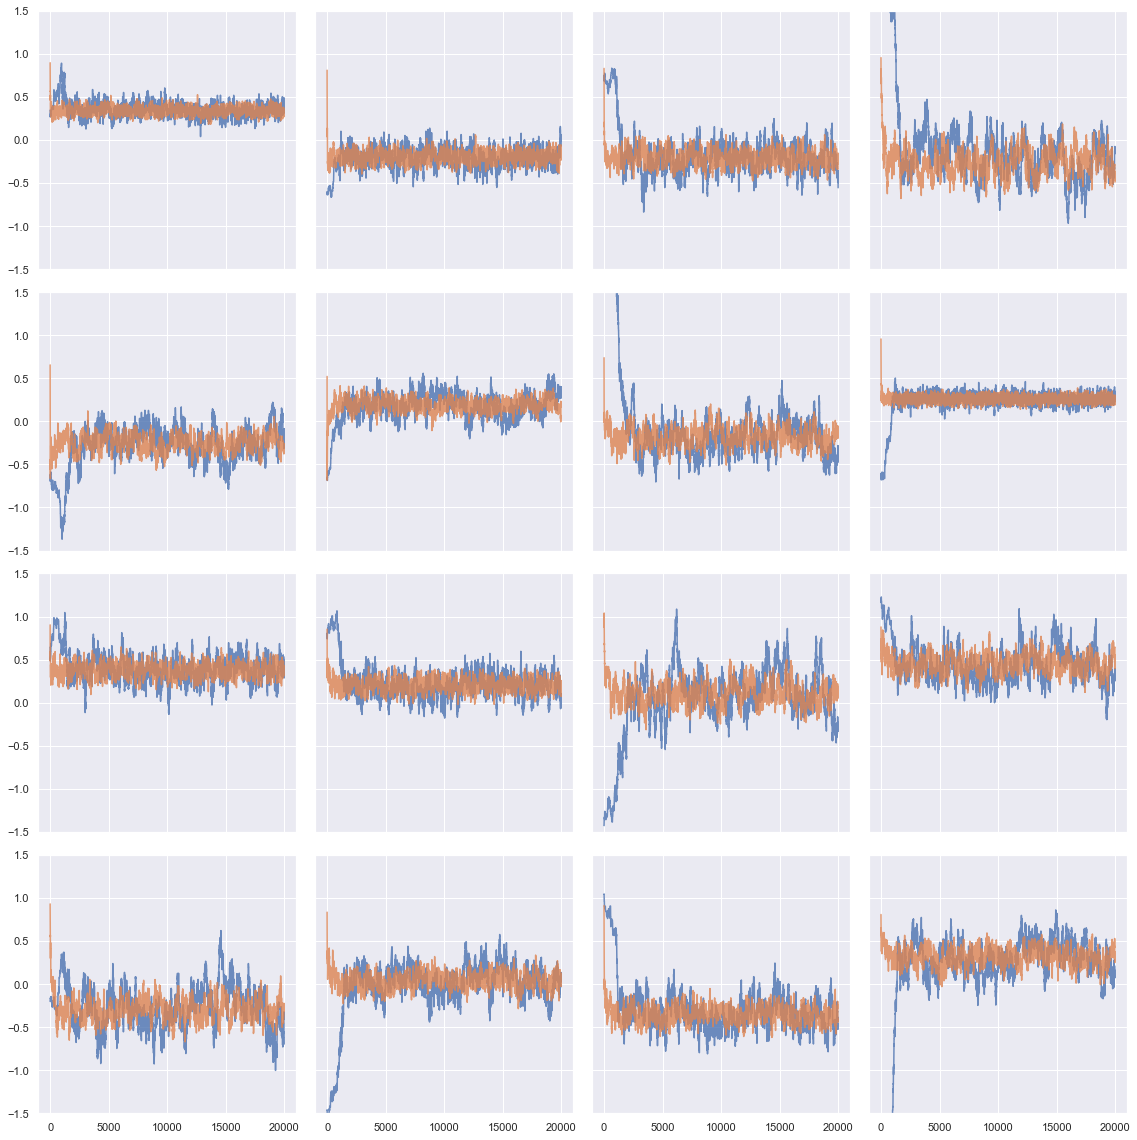

In [20]:
compare_samples_MH(samples_student_rw,samples_student_langevin)

### extraction of the estimates from the models

In [21]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH      HISP  \
gd                  0.773617  0.351708 -0.185607 -0.204572 -0.212706   
line_search_gd      0.773617  0.351707 -0.185607 -0.204573 -0.212708   
Wolfe_cond_gd       0.818362  0.425715 -0.141207  0.071222  0.339407   
MH_vanilla_mean     0.791575  0.346506 -0.185218 -0.203708 -0.182186   
MH_vanilla_median   0.789661  0.345224 -0.188847 -0.209443 -0.165727   
MH_Langevin_mean    0.779349  0.348390 -0.182483 -0.208415 -0.189952   
MH_Langevin_median  0.779030  0.347800 -0.183045 -0.205194 -0.196717   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.239065  0.169971 -0.162226  0.258266  0.385553   
line_search_gd     -0.239071  0.169967 -0.162219  0.258266  0.385554   
Wolfe_cond_gd      -0.358303 -0.125175 -0.051975  0.307898  0.360160   
MH_vanilla_mean    -0.265598  0.146778 -0.137859  0.259629  0.391453   
MH_vanilla_median  -0.258529  0.142866 -0.143748  0.260417  0.390630   
MH_Langevin_mean   -0.246948  0.167400 -0.151311  0.258555  0.380550   
MH_Langevin_median -0.245322  0.161972 -0.150834  0.258885  0.380613   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.212762  0.141787  0.393538 -0.297686  0.025750   
line_search_gd      0.212764  0.141789  0.393543 -0.297681  0.025755   
Wolfe_cond_gd       0.321533  0.439163  0.429924  0.276374  0.182567   
MH_vanilla_mean     0.228998  0.123064  0.415461 -0.223036  0.047965   
MH_vanilla_median   0.234469  0.131872  0.427379 -0.224898  0.047988   
MH_Langevin_mean    0.210247  0.127701  0.401683 -0.288258  0.019965   
MH_Langevin_median  0.211808  0.127106  0.401930 -0.286938  0.017650   

                        SERV      PROF  
gd                 -0.345086  0.297529  
line_search_gd     -0.345082  0.297534  
Wolfe_cond_gd       0.044369  0.354095  
MH_vanilla_mean    -0.332363  0.322636  
MH_vanilla_median  -0.331053  0.329148  
MH_Langevin_mean   -0.342938  0.305564  
MH_Langevin_median -0.348183  0.309225

In [22]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH      HISP  \
gd                   6.712761  0.339442 -0.204348 -0.240619 -0.297141   
line_search_gd      18.744119  0.341741 -0.197535 -0.220067 -0.256264   
Wolfe_cond_gd        7.886129  0.339471 -0.203319 -0.236226 -0.289781   
MH_vanilla_mean     24.561249  0.344956 -0.198171 -0.220106 -0.208379   
MH_vanilla_median   23.568695  0.344796 -0.200949 -0.211583 -0.206839   
MH_Langevin_mean    23.425146  0.340562 -0.193684 -0.212670 -0.267594   
MH_Langevin_median  23.028099  0.342176 -0.192604 -0.217827 -0.267233   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.265343  0.207036 -0.187721  0.264383  0.365828   
line_search_gd     -0.251051  0.190463 -0.178088  0.260819  0.373601   
Wolfe_cond_gd      -0.262365  0.204278 -0.186288  0.263679  0.366979   
MH_vanilla_mean    -0.236525  0.191889 -0.194912  0.262824  0.381190   
MH_vanilla_median  -0.236044  0.193441 -0.198429  0.263636  0.382274   
MH_Langevin_mean   -0.251262  0.189994 -0.177000  0.258960  0.377289   
MH_Langevin_median -0.249048  0.187633 -0.182308  0.257987  0.377715   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.205246  0.122555  0.503613 -0.280387  0.059641   
line_search_gd      0.206468  0.129351  0.461792 -0.290331  0.042638   
Wolfe_cond_gd       0.205153  0.123364  0.496686 -0.282771  0.056253   
MH_vanilla_mean     0.190270  0.134183  0.426472 -0.291130  0.044364   
MH_vanilla_median   0.193822  0.119607  0.413503 -0.295465  0.048179   
MH_Langevin_mean    0.204980  0.099049  0.453890 -0.298239  0.043125   
MH_Langevin_median  0.205838  0.094432  0.450363 -0.302537  0.044896   

                        SERV      PROF  
gd                 -0.359384  0.313164  
line_search_gd     -0.351271  0.308540  
Wolfe_cond_gd      -0.357893  0.312395  
MH_vanilla_mean    -0.345800  0.303694  
MH_vanilla_median  -0.346262  0.301131  
MH_Langevin_mean   -0.352106  0.314336  
MH_Langevin_median -0.351947  0.319676

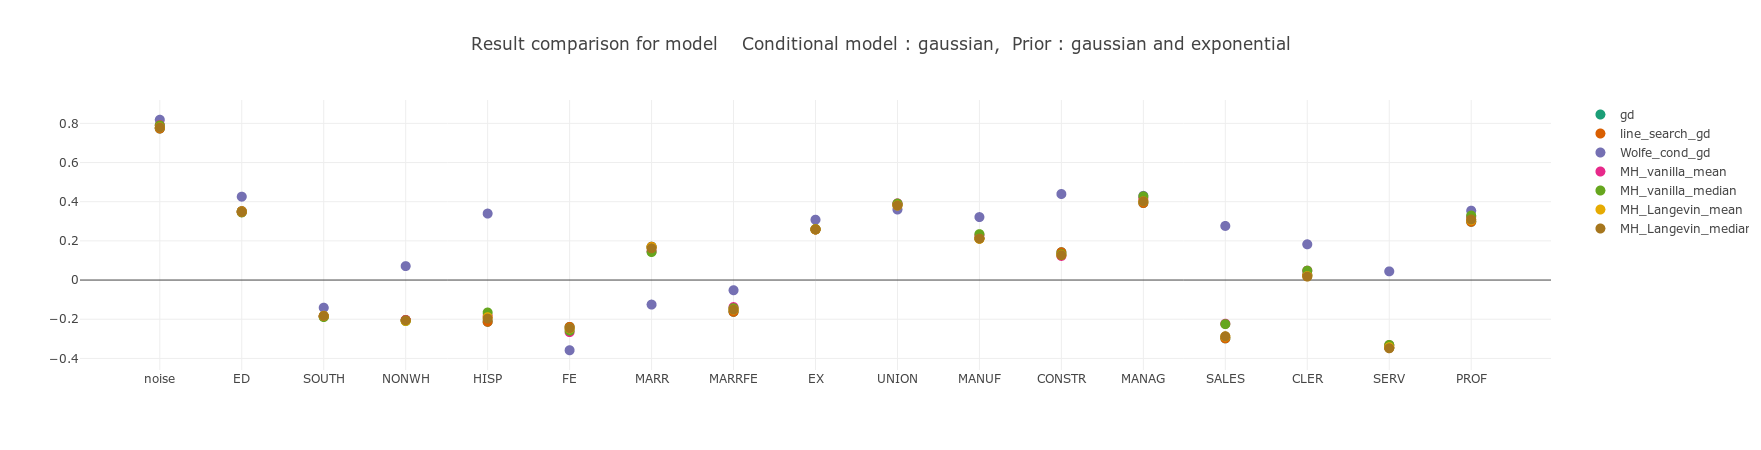

In [23]:
visualisation(r_gaussian,model_gaussian)

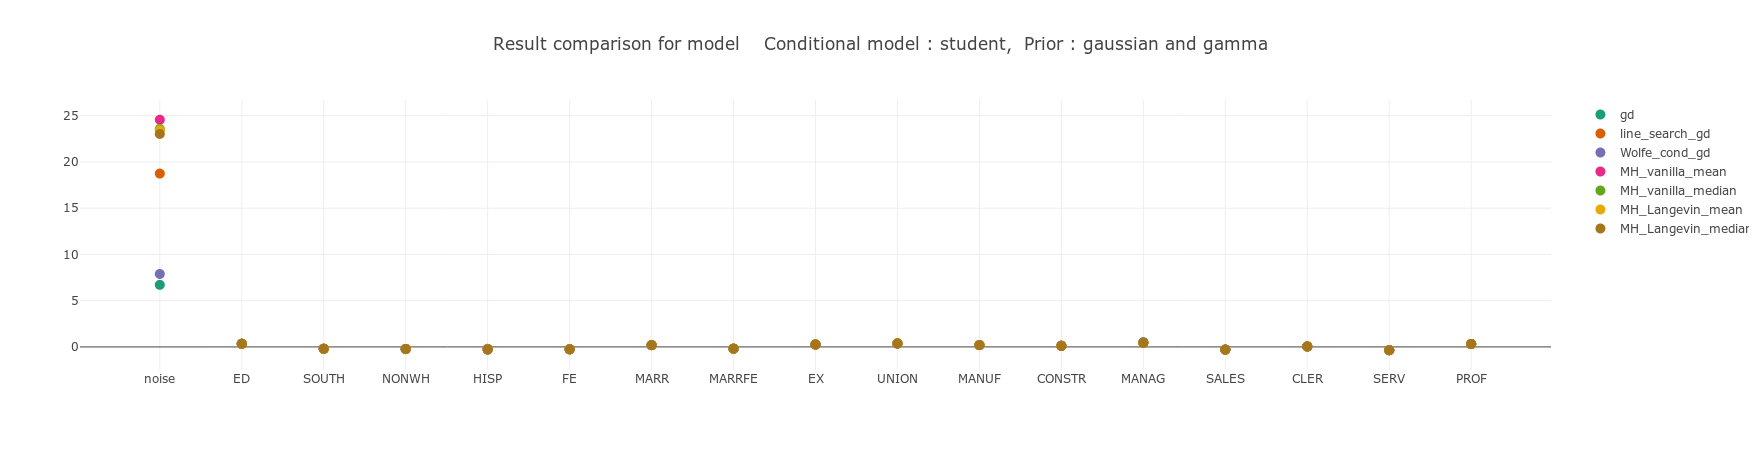

In [24]:
visualisation(r_student,model_student)

## Accuracy of the prediction

In order to predict, we have to use : $$ f(y| D = d) = \int f(y,\theta|D = d)d\theta = \int f(y|\theta)f(\theta|D=d)d\theta$$
Since we suppose our data are iid, the dependence of $y$ to $D$ is only through $\theta$



Supposing we want to approximate $y$ by its mean in the case of our first model, with the gaussian noise, gaussian prior on $\beta$ and exponential prior on $\sigma$:

\begin{align} \mathbb{E}[y|D=d] &= \int y f(y|D=d)dy \\
&= \int y \int f(y|\theta)f(\theta|D=d)d\theta dy \\
&= \int\int y f(y|\theta)f(\theta|D=d)d\theta dy\\
&= \int\left( \int y f(y|\theta)dy \right) f(\theta|D=d)d\theta \\
&= \int x^T\beta f(\theta|D=d)d\theta \\ 
&= \mathbb{E}_{\theta \sim \theta|D=d}[x^T\beta]\\
&= x^T \widehat{\beta}
\end{align}

So supposing we can switch the integrals (using Fubini since both functions are positive (densities) and the integral $\int y f(y|\theta)f(\theta|D=d)d\theta dy $ is finite ), the point prediction can be done by either marginalizing out the $\theta$, or by first finding the "optimal" theta and then predicting the MAP of the conditional model. This is logic given that the marginalization of the $\theta$ is there because we do not know the distribution of the $\theta$, but only its distribution. But if we are interested in a point estimate, this inflation in the uncertainty of our precision is not directly usefull.


For our second model, the same development holds.

Otherwise we could just use the samples from the previous run of our Metropolis Hasting algorithms and for each $\theta$ sampled, compute a prediction $x^T\theta$ and then compute a statistic on these. 

When using the samples from Metropolis-Hastings algorithm, we will make a gaussian approximation of our posterior, so the MAP will be the mean or the median. Since this is an approximation, we will use both mean and median to see if there is any discrepancies in our reasonning.

In [25]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_gaussian.index = ["error on test","error on train"]
errors_gaussian.T

error on test  error on train
gd                       0.685706        0.613765
line_search_gd           0.685706        0.613765
Wolfe_cond_gd            0.692771        0.651932
MH_vanilla_mean          0.685615        0.613861
MH_vanilla_median        0.685989        0.613901
MH_Langevin_mean         0.685224        0.614216
MH_Langevin_median       0.685498        0.614049

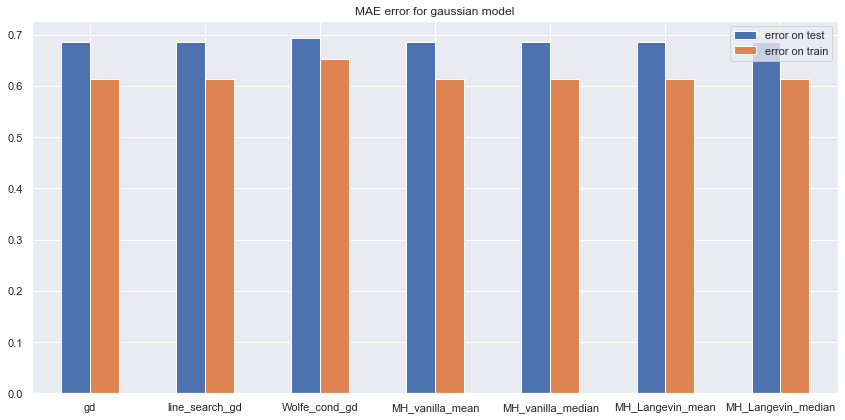

In [26]:
big_plot(12,6)
errors_gaussian.T.plot.bar()
plt.xticks(rotation="horizontal")
plt.title("MAE error for gaussian model")
plt.tight_layout()
reset_plot()

In [27]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_student.index = ["error on test","error on train"]
errors_student.T

error on test  error on train
gd                       0.685277        0.609905
line_search_gd           0.685159        0.611209
Wolfe_cond_gd            0.685230        0.610147
MH_vanilla_mean          0.684375        0.612619
MH_vanilla_median        0.683920        0.612945
MH_Langevin_mean         0.684276        0.611675
MH_Langevin_median       0.683867        0.611847

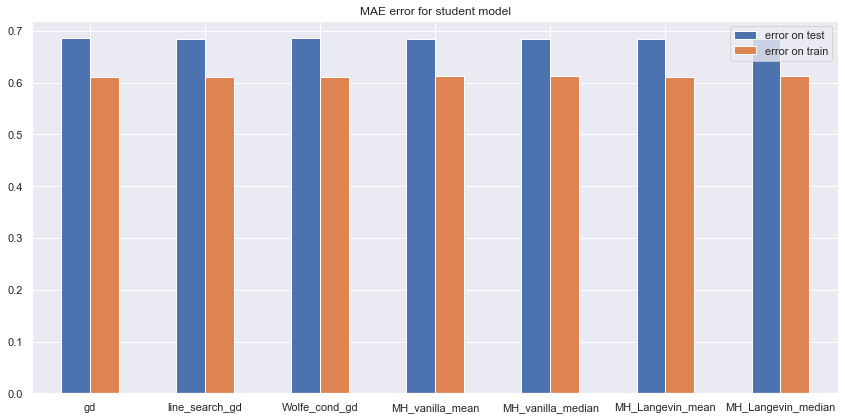

In [28]:
big_plot(12,6)
errors_student.T.plot.bar()
plt.xticks(rotation="horizontal")
plt.title("MAE error for student model")
plt.tight_layout()
reset_plot()

# Classification 

`multilogi`:

- Conditional model
$$\mathbb{P}\left(Y=1|X\right) = \frac{e^{X^T\beta}}{1+e^{X^T\beta}}$$

- Prior:
$$\beta \sim N(0,3^2I) $$

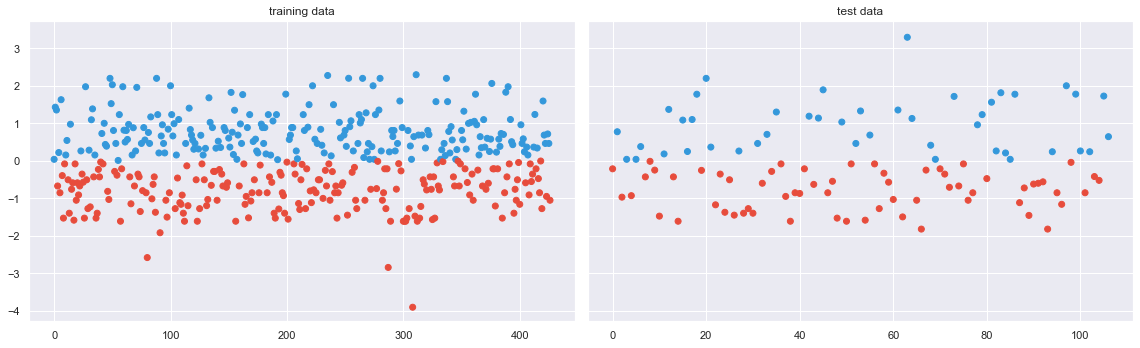

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

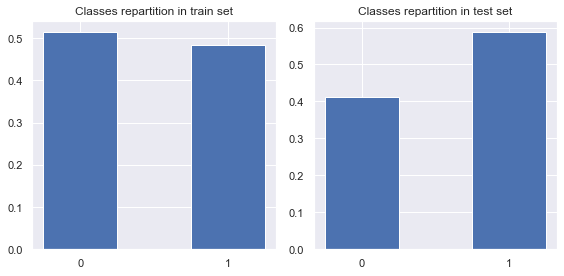

In [30]:
plt.subplot(121)
plt.bar([0.4,0.8],[len(classes[classes==0])/len(classes),len(classes[classes==1])/len(classes)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in train set")
plt.subplot(122)
plt.bar([0.4,0.8],[len(classes_test[classes_test==0])/len(classes_test),len(classes_test[classes_test==1])/len(classes_test)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in test set")
plt.tight_layout()
plt.show()

adding an intercept

In [75]:
X_intercept = np.append(X, np.ones((X.shape[0],1)), axis = 1)
X_intercept_test = np.append(X_test, np.ones((X_test.shape[0],1)), axis = 1)

In [78]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X_intercept,response = classes, Prior = [0,3*np.ones(17)],cond_model = [2])

In [79]:
GD.vanilla_gd(multilogi, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:08


In [80]:
GD.line_search_gd(multilogi, lambda_ = 1e-3,x0 = np.ones(multilogi.size),max_iter = 8000)

Progress : [====================] 100% Done...
 converged early at iteration 7180  duration: 0:00:09


In [81]:
GD.Wolfe_cond_gd(multilogi, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(multilogi.size))

Progress : [====================] 100% Done...
   duration: 0:00:11


Progress : [====================] 100% Done...
  Acceptance rate : 34.1%  (advised values between 10% and 50%)
  duration: 0:00:23
iterations


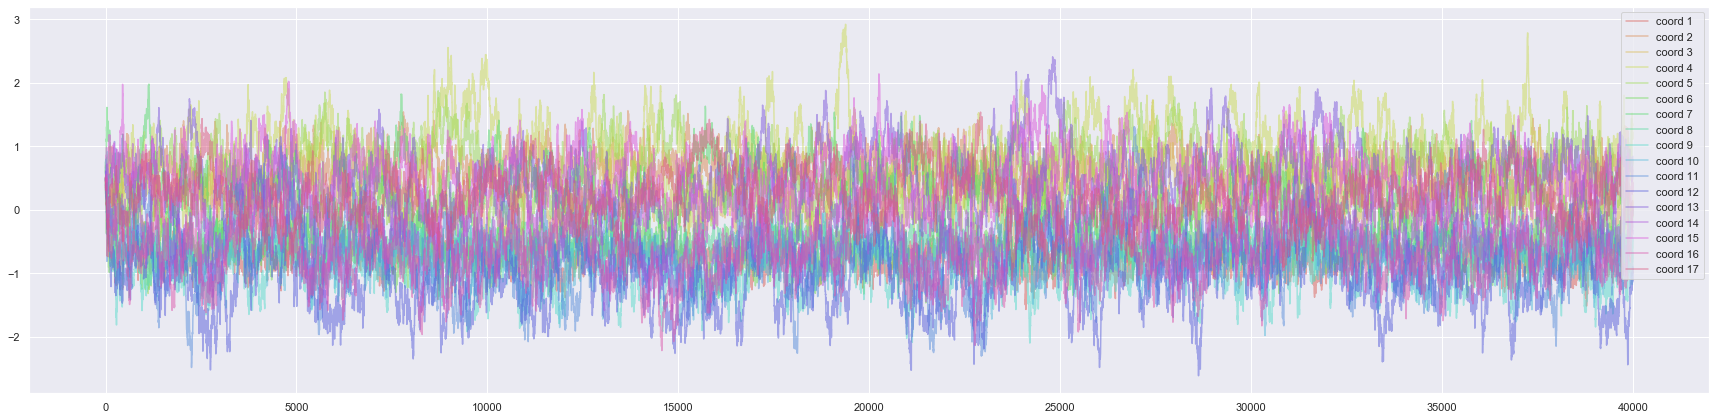

In [82]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_rw = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_rw, distribution=False, correlation= False)

Progress : [====================] 100% Done...
  Acceptance rate : 16.1%                 (advised values between 10% and 50%)
  duration: 0:01:12
iterations


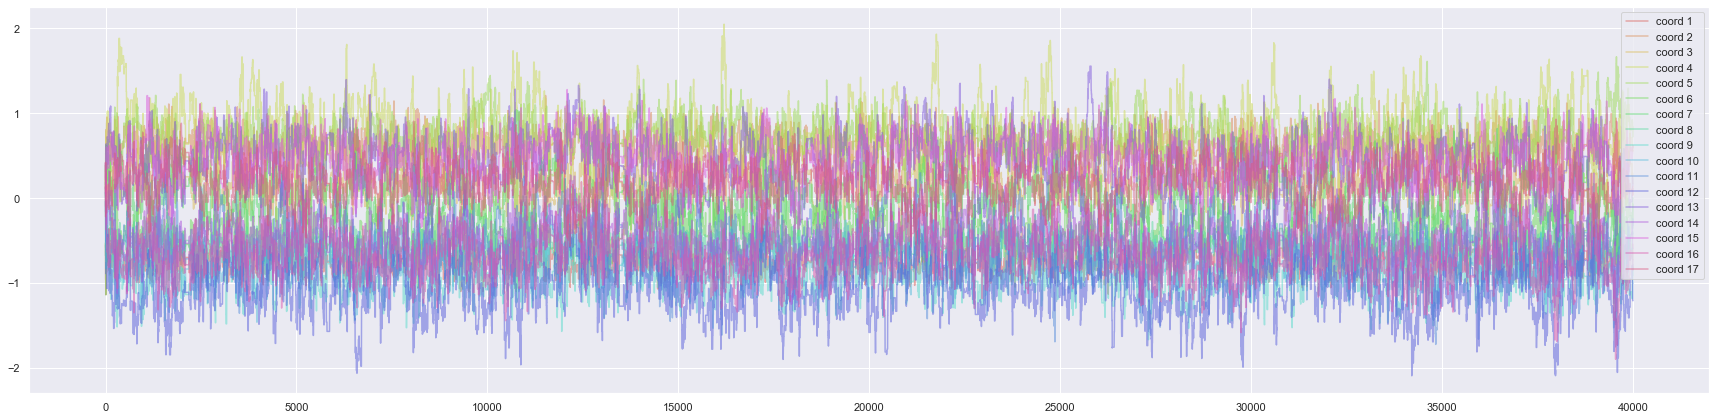

In [83]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_langevin = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)
    samples_exploration(samples_classification_langevin, distribution=False, correlation= False)

In [84]:
r_multilogi = multilogi()
r_multilogi.T

interc        ED     SOUTH     NONWH      HISP  \
gd                 -0.738891  0.615104  0.175839  0.751180  0.687774   
line_search_gd     -0.727606  0.615014  0.172432  0.725311  0.667833   
Wolfe_cond_gd      -0.730117  0.615129  0.172585  0.725226  0.667163   
MH_vanilla_mean    -0.762698  0.674474  0.175940  0.829804  0.597541   
MH_vanilla_median  -0.759849  0.668048  0.171663  0.838261  0.574323   
MH_Langevin_mean   -0.739637  0.636776  0.171707  0.725796  0.685987   
MH_Langevin_median -0.736005  0.633254  0.170683  0.711500  0.687790   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.347491 -0.037167 -0.553418 -0.892980 -0.666306   
line_search_gd     -0.374821  0.005216 -0.544622 -0.906227 -0.710789   
Wolfe_cond_gd      -0.373009  0.002493 -0.546113 -0.903416 -0.703239   
MH_vanilla_mean    -0.433119  0.116961 -0.568061 -0.926658 -0.754522   
MH_vanilla_median  -0.441814  0.138028 -0.563120 -0.916801 -0.751636   
MH_Langevin_mean   -0.363541 -0.002576 -0.556088 -0.916631 -0.730559   
MH_Langevin_median -0.361379 -0.001270 -0.556094 -0.911335 -0.728122   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                 -0.471651 -0.983772  0.484555 -0.371869  0.495563   
line_search_gd     -0.560794 -1.065768  0.419083 -0.440443  0.424430   
Wolfe_cond_gd      -0.549398 -1.050038  0.434206 -0.427211  0.437437   
MH_vanilla_mean    -0.641111 -1.065661  0.477215 -0.430205  0.475380   
MH_vanilla_median  -0.659042 -1.075322  0.469658 -0.444565  0.459736   
MH_Langevin_mean   -0.567804 -1.082781  0.420955 -0.456895  0.433870   
MH_Langevin_median -0.556898 -1.077597  0.417051 -0.459939  0.434608   

                        SERV      PROF  
gd                 -0.589773  0.108041  
line_search_gd     -0.658903  0.189245  
Wolfe_cond_gd      -0.644640  0.176755  
MH_vanilla_mean    -0.661115  0.201639  
MH_vanilla_median  -0.680952  0.193679  
MH_Langevin_mean   -0.685279  0.179841  
MH_Langevin_median -0.686746  0.179658

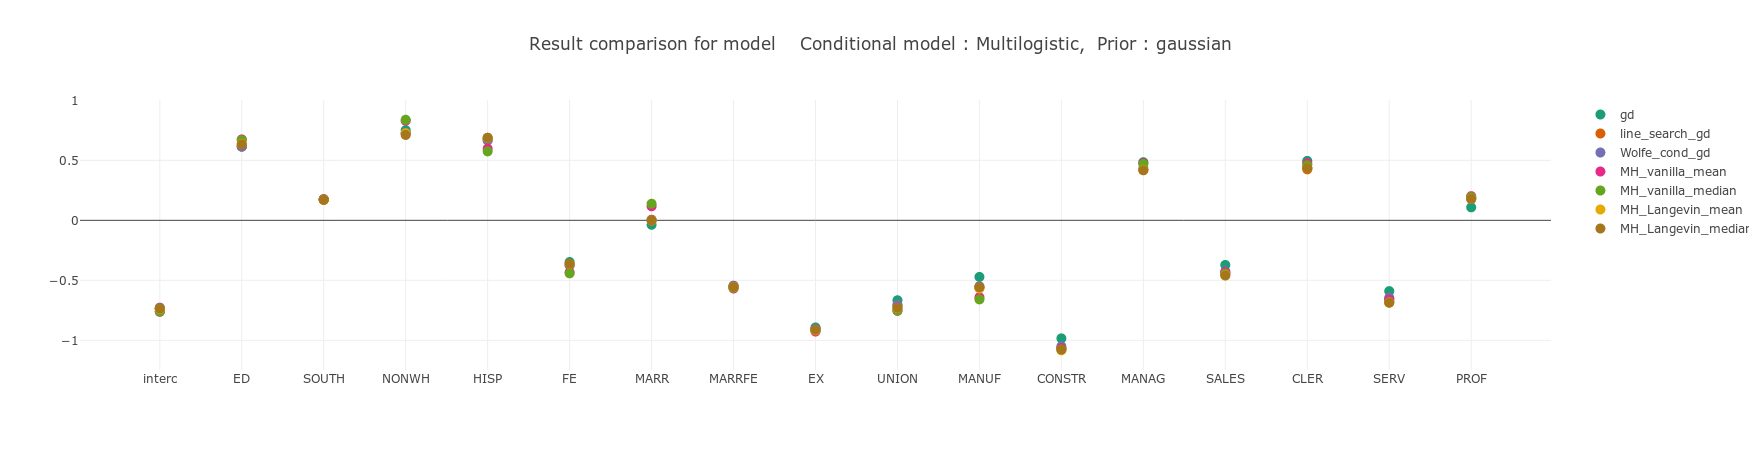

In [93]:
visualisation(r_multilogi,multilogi)

## Results of logistic regression

In order to predict, we will minimize the misclassification error, which mean we will use the decision boundary $\mathbb{P}[Y=1|x]>=0.5$.

Following Bishop _Pattern recognition and Machine learning_, p.220, we first compute the MAP of our parameter $\beta$, and then use it to predict our classes using the decisin boundary above.

When using the samples from Metropolis-Hastings algorithm, we will make a gaussian approximation of our posterior, so the MAP will be the mean or the median. Since this is an approximation, we will use both mean and median to see if there is any discrepancies in our reasonning.

In [86]:
predictions = multilogi.predict(X_intercept_test)
fitted = multilogi.predict(X_intercept)

In [87]:
errors = {}

In [88]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes_test))
    else:
        errors[name] = [error/len(classes_test)]

In [89]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes))
    else:
        errors[name] = [error/len(classes)]

In [90]:
errors = pd.DataFrame(errors)
errors.index = ["error on test", "error on train"]
errors.T

error on test  error on train
gd                       0.467290        0.271663
line_search_gd           0.467290        0.281030
Wolfe_cond_gd            0.467290        0.281030
MH_vanilla_mean          0.448598        0.274005
MH_vanilla_median        0.457944        0.276347
MH_Langevin_mean         0.467290        0.278689
MH_Langevin_median       0.467290        0.278689

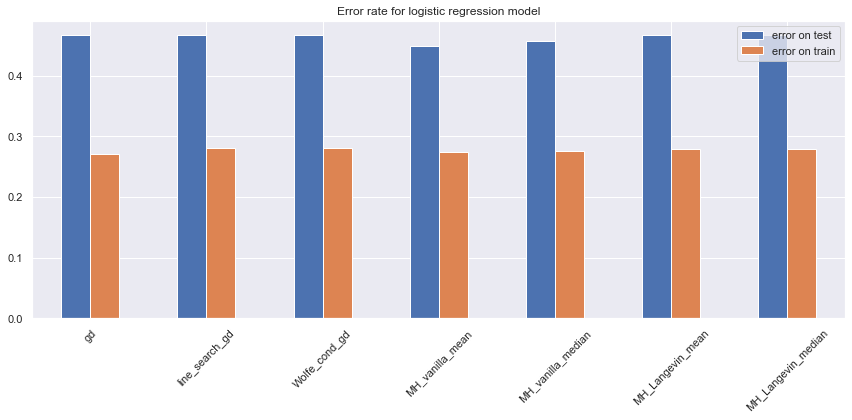

In [91]:
big_plot(12,6)
errors.T.plot.bar()
plt.xticks(rotation=45)
plt.title("Error rate for logistic regression model")
plt.tight_layout()
reset_plot()